In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr 
import scipy.stats as sp

In [2]:
meta_path = '../metadata_all_pairs_mb.json'

# read file
with open(meta_path, 'r') as myfile:
    data=myfile.read()

# parse file
meta = json.loads(data)

In [3]:
datapath = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/classification/'
datafile = 'trialdata_faces_classification_task_02_04_2022.csv'
data = pd.read_csv(datapath+datafile)
data = data[(data.experiment_id != '9be974urmy8wojz5b1kn') & (data.experiment_id != 'px9sufzovs6fmvr1xfsj')]

In [4]:
# want option of matching race, gender, facial hair
# pairs: model_similar, model_group, behavior_similar, behavior_group
# for now, just do behavior_similar
key_race = {
    'black': 0,
    'white': 1,
    'east_asian': 2,
    'south_asian': 3,
    'latinx': 4,
    'other': 5,
}
key_gender = {
    'woman': 0,
    'man': 1,
    'other': 2,
}
# backwards
key_race2 = {
    0: 'black',
    1: 'white',
    2: 'east_asian',
    3: 'south_asian',
    4: 'latinx',
    5: 'other',
}
key_gender2 = {
    0: 'woman',
    1: 'man',
    2: 'other',
}

In [5]:
ids = list(meta.keys())
info = {} # where I will store all my data
for item in meta.keys():
    info[item] = {
        'race_counts': [0,0,0,0,0,0],
        'gender_counts': [0,0,0],
        'facial_hair': meta[item]['facial_hair']
    }

In [6]:
# loop through data.
# loop through each race in response_race (excluding numbers) 
# and add response_race_sure to respective categories
# same with gender
count = 0
test = []
for i in range(len(data)):
    
    curr_id = data.iloc[i]['stimulus'][2:5] # id
    test.append(data.iloc[i]['response_gender_sure'])
    
    for item in key_race.keys():
        if item in data.iloc[i]['response_race']:
            slider = data.iloc[i]['response_race_sure']
            if slider == 0: slider = 100
            info[curr_id]['race_counts'][key_race[item]] += slider 
            # info[curr_id]['race_counts'][key_race[item]] += 1
    
    for item in key_gender.keys():
        if item == 'man':
            # only add if 'wo' is not present before man
            resp = data.iloc[i]['response_gender']
            if item in resp and resp[resp.index('man')-2:resp.index('man')] != 'wo':# CAREFUL:'MAN' is in 'WOMAN'
                if slider == 0: slider = 100
                info[curr_id]['gender_counts'][key_gender[item]] += slider
                 #info[curr_id]['gender_counts'][key_gender[item]] += 1 
        else:
            # add just if the item is there
            if item in data.iloc[i]['response_gender']: # THIS IS THE ISSUE. 'MAN' is in 'WOMAN'
                if slider == 0: slider = 100
                info[curr_id]['gender_counts'][key_gender[item]] += slider
                 #info[curr_id]['gender_counts'][key_gender[item]] += 1 

In [7]:
# get race_similarity scores and gender similarity scores for each face
# then get ranked order of average of those scores
# + a version where facial hair has to match

# loop through items. for each one, loop through all other items.
# for each pair, compute a race similarity score, a gender similarity score, and an average score

# first, give each item an array of tuples containing [ ('other_id', corr), ... ]
corrs = {
    'race': {},
    'gender': {},
    'mean': {}
}

for i in info.keys():
    corrs['race'][i] = []
    corrs['gender'][i] = []
    corrs['mean'][i] = []
    
    for j in info.keys():
        if (i!=j): # for all id's besides this one
            # get race corr, gender corr, mean corr
            race_corr = pearsonr(info[i]['race_counts'], info[j]['race_counts'])[0]
            corrs['race'][i].append((j, race_corr))
            gender_corr = pearsonr(info[i]['gender_counts'], info[j]['gender_counts'])[0]
            corrs['gender'][i].append((j, gender_corr))
            
            mean_corr = np.mean((race_corr, gender_corr))
            corrs['mean'][i].append((j, mean_corr))

In [8]:
# now, I want to sort by mean_corr to get a sorted array of all other faces
mean_corr_sorted = {}
for k,v in corrs['mean'].items():
    mean_corr_sorted[k] = [key for key, value in sorted(v, key = lambda x: x[1], reverse=True)]

In [9]:
sorted_hair_match = {}
for k,v in mean_corr_sorted.items():
    sorted_hair_match[k] = [idy for idy in v if info[idy]['facial_hair'] == info[k]['facial_hair']]

In [10]:
# now, have mean_corr_sorted and sorted_hair_match
for key in meta.keys():
    meta[key]['pairs'] = {
        'behavior_similar': mean_corr_sorted[key],
        'behavior_similar_hairmatch': sorted_hair_match[key]
    }

In [11]:
# how many faces were white most of the time?
ans = [0,0,0,0,0,0] #black, white, east asian, south asian, latinx, other{
for k in info.keys():
    m = np.argmax(info[k]['race_counts'])
    ans[m] = ans[m]+1
ans 

[56, 56, 2, 3, 39, 0]

In [55]:
# NOTE: KMEANS DOESN'T WORK WELL BECAUSE WANTS EVEN SIZES
# clustering based on just race (and gender?)
dat = pd.DataFrame(columns = ['black', 'white', 'east_asian', 'south_asian', 'latinx', 'other'])
len(dat)
for k in info.keys():
    dat.loc[len(dat)] = info[k]['race_counts']

In [56]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=6, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
fit = km.fit(dat)

In [118]:
fit.labels_
counts = [0,0,0,0,0,0]
for i in fit.labels_:
    counts[i] = counts[i] + 1
counts

[29, 34, 28, 35, 28, 2]

In [57]:
# INSTEAD, ADD behavior_group BY MOST COMMON CATEGORY

# to each ID in meta, add race_common, gender_common, and pairs for:
# behavior_group, behavior_group_gender, behavior_group_hairmatch, behavior_group_gender_hairmatch

for k in info.keys(): # loop through IDs
    
    # first get, most common race and gender judgements for that face
    meta[k]['race_common'] = key_race2[np.argmax(info[k]['race_counts'])]
    meta[k]['gender_common'] = key_gender2[np.argmax(info[k]['gender_counts'])]

In [ ]:
# new stuff for AFC purposes

In [89]:
count = 0
for k in meta.keys():
    if meta[k]['race_common'] in ['white','black']:
        count += 1
print(count) # 

120


In [25]:
# now, because we need 8 more faces, we are going to get the 4 closest to white that weren't white 
# and the 4 closest to black that weren't black
ids = []
for k in meta.keys():
    if meta[k]['race_common'] not in ['white','black']:
        ids.append(k)
print(len(ids))

44


In [36]:
races = {}
for i in ids:
    curr = info[i]['race_counts'].copy()
    curr = [x / sum(curr) for x in curr]
    races[i] = curr
# this now contains proportion of responses for each category

In [53]:
def big_enough(v,arr):
    for i in range(len(arr)):
        if (v > arr[i]):
            return True
    return False

In [63]:
# get the 4 identities with highest values in index 0 and highest values in index 1
top4_w = [0,0,0,0]
top4_b = [0,0,0,0]

for k,v in races.items():
    if big_enough(v[0], top4_b):
        top4_b[np.argmin(top4_b)] = v[0]
        top4_b_i.append(k)
        
    if big_enough(v[1], top4_w):
        top4_w[np.argmin(top4_w)] = v[1]
        top4_w_i.append(k)

In [78]:
w = []
b = []
for k,v in races.items():
    if v[0] in top4_b:
        b.append(k)
    if v[1] in top4_w:
        w.append(k)
        
print('white: \n', w)
print('black: \n', b)
print('These are the top identities that we want to manually change to get more faces')

white: 
 ['131', '042', '150', '037']
black: 
 ['033', '072', '046', '107']
These are the top identities that we want to manually change to get more faces


In [88]:
for i in w:
    meta[i]['race_common'] = 'white' # manually override
for i in b:
    meta[i]['race_common'] = 'black'

In [87]:
# correcting some errors made to original metadata - no longer need to run
meta['044']['facial_hair'] = '2.0'
meta['021']['facial_hair'] = '2.0'
meta['102']['facial_hair'] = '0.0'
meta['141']['facial_hair'] = '0.0'

In [90]:
# next, loop through all others faces and add ones that fall in the same group
for k in info.keys():
    
    meta[k]['pairs']['behavior_group'] = []
    meta[k]['pairs']['behavior_group_gender'] = []
    meta[k]['pairs']['behavior_group_hairmatch'] = []
    meta[k]['pairs']['behavior_group_hairmatch_bin'] = []
    meta[k]['pairs']['behavior_group_gender_hairmatch'] = []
    meta[k]['pairs']['behavior_group_gender_hairmatch_bin'] = []
    

    for j in info.keys():
        if k!=j:
            if meta[k]['race_common'] == meta[j]['race_common']:
                meta[k]['pairs']['behavior_group'].append(j) # if same race_common, add to behavior_group
                
                if meta[k]['gender_common'] == meta[j]['gender_common']:
                    meta[k]['pairs']['behavior_group_gender'].append(j) # if also same gender_common, add to behavior_group_gender
                    
                    if meta[k]['facial_hair'] == meta[j]['facial_hair']:
                        meta[k]['pairs']['behavior_group_gender_hairmatch'].append(j) # if also same facial_haair, add to behavior_group_gender_hairmatch
                    if (meta[k]['facial_hair']=='0.0') == (meta[j]['facial_hair']=='0.0'):
                        meta[k]['pairs']['behavior_group_gender_hairmatch_bin'].append(j) # if also same facial_haair, add to behavior_group_gender_hairmatch
                        
                # here: doesn't have to match gender, does have to match race
                if info[k]['facial_hair'] == info[j]['facial_hair']:
                    meta[k]['pairs']['behavior_group_hairmatch'].append(j)
                if (meta[k]['facial_hair']=='0.0') == (meta[j]['facial_hair']=='0.0'):
                        meta[k]['pairs']['behavior_group_hairmatch_bin'].append(j) # if also same facial_hair, add to behavior_group_gender_hairmatch


In [91]:
# export meta as new json file
with open('../metadata_all_pairs_mb_altered.json', 'w') as file:
    file.write(json.dumps(meta)) # use `json.loads` to do the reverse

In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# white: 
#  ['131', '042', '150', '037']
# black: 
#  ['033', '072', '046', '107']


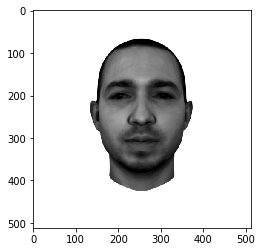

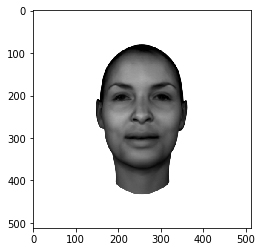

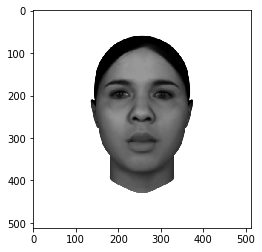

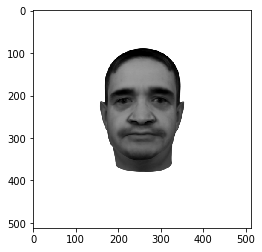

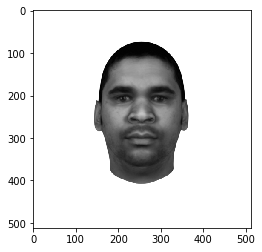

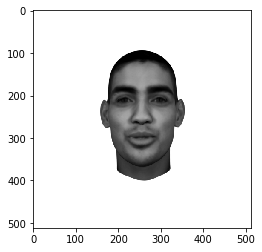

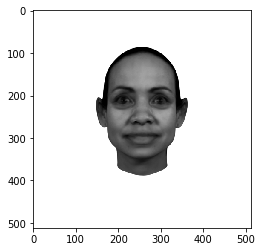

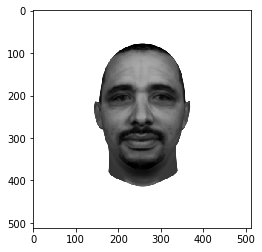

In [104]:
imstart = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/stimuli/version1_gray_lm/id'
imend = '_00C_C.png'
for id_ in w:
    img = mpimg.imread(imstart + id_ + imend)
    imgplot = plt.imshow(img)
    plt.show()
for id_ in b:
    img = mpimg.imread(imstart + id_ + imend)
    imgplot = plt.imshow(img)
    plt.show()
